## Dependencias

## Dependencias 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

## Cargar Datos

In [ ]:
data = pd.read_sas('../data/churn.sas7bdat')
data.shape

In [ ]:
data.head()

## Partición

In [ ]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

## Naturaleza de variables 

In [ ]:
um = ['ID']
varc = [v for v in data.columns if v[:2]=='V_']
#vard = [v for v in data.columns if v[:2]=='C_']
vart = ['TARGET']
len(varc)#,len(vard)

## Cambio de escala $\mathcal{X}_{[0,1]}$

In [15]:
X = train[varc].copy()
sc = MinMaxScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=X.columns)

## Híper-parametrización

In [34]:
mod = MLPClassifier()

In [35]:
hp = {"hidden_layer_sizes" : [(a,b,) for a in range(2,6) for b in range(2,6)],
"activation" : ['identity', 'logistic', 'tanh', 'relu'],
"solver" : ['lbfgs', 'sgd', 'adam'],
"learning_rate" : ['constant', 'invscaling', 'adaptive'],
"max_iter" : [1000]
}
reduce(lambda x,y:x*y,[len(hp[i]) for i in hp]) 

576

In [36]:
grid = RandomizedSearchCV(param_distributions=hp,
                          estimator=mod,
                          n_iter=50,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1)
grid.fit(Xs,train[vart[0]])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/josegustavofuentescabrera/Documents

RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(2, 2), (2, 3),
                                                               (2, 4), (2, 5),
                                                               (3, 2), (3, 3),
                                                               (3, 4), (3, 5),
                                                               (4, 2), (4, 3),
                                                               (4, 4), (4, 5),
                                                               (5, 2), (5, 3),
                                                               (5, 4), (5, 5)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='roc_auc')

In [37]:
grid.best_score_,grid.best_params_

(np.float64(0.8388621941313839),
 {'solver': 'lbfgs',
  'max_iter': 1000,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (4, 5),
  'activation': 'relu'})

## Aprendizaje $\vec{\theta} = \{w_{ij}\}$

In [38]:
mod = grid.best_estimator_
mod

MLPClassifier(hidden_layer_sizes=(4, 5), max_iter=1000, solver='lbfgs')

In [39]:
mod.fit(Xs, train[vart[0]])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(4, 5), max_iter=1000, solver='lbfgs')

## Pesos de la red $\vec{\theta}$

In [40]:
[w.shape for w in mod.coefs_]

[(10, 4), (4, 5), (5, 1)]

In [41]:
train['proba'] = mod.predict_proba(sc.transform(train[varc]))[:,1]
valid['proba'] = mod.predict_proba(sc.transform(valid[varc]))[:,1]

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [42]:
print('AUC train:',roc_auc_score(train[vart[0]],mod.predict_proba(sc.transform(train[varc]))[:,1]))
print('AUC valid:',roc_auc_score(valid[vart[0]],mod.predict_proba(sc.transform(valid[varc]))[:,1]))

AUC train: 0.8840833475561062
AUC valid: 0.8452041387024608


/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


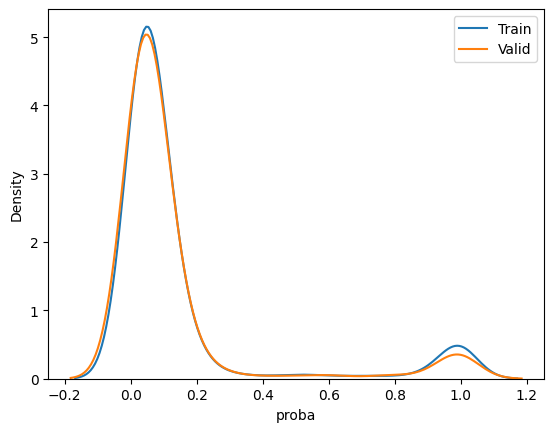

In [43]:
sns.kdeplot(train['proba'], label='Train')
sns.kdeplot(valid['proba'], label='Valid')
plt.legend()

In [44]:
train['r_proba'] =pd.cut(train['proba'], bins=np.arange(0,1.2,0.2), include_lowest=True).astype(str)
valid['r_proba'] =pd.cut(valid['proba'], bins=np.arange(0,1.2,0.2), include_lowest=True).astype(str)

In [46]:
cubo_train = train[['r_proba']+vart+um].groupby(['r_proba']+vart).count().reset_index().assign(muestra='ent')
cubo_valid = valid[['r_proba']+vart+um].groupby(['r_proba']+vart).count().reset_index().assign(muestra='val')

In [47]:
cubo = pd.concat([cubo_train,cubo_valid],ignore_index=True)

In [48]:
cubo.to_clipboard(index=False)